The tagging system used by Stack Exchange looks just like what we need to solve this problem as it allow us to quantify how many questions are asked about each subject.

Something else we can learn from exploring the help center, is that Stack Exchange's sites are heavily moderated by the community; this gives us some confidence in using the tagging system to derive conclusions.
What information is available in each post?¶

Looking, just as an example, at this question, some of the information we see is:

    For both questions and answers:
        The posts's score;
        The posts's title;
        The posts's author;
        The posts's body;
    For questions only:
        How many users have it on their "
        The last time the question as active;
        How many times the question was viewed;
        Related questions;
        The question's tags;

Stack Exchange Data Explorer

Perusing the table names, a few stand out as relevant for our goal:

    Posts
    PostTags
    Tags
    TagSynonyms

Running a few exploratory queries, leads us to focus our efforts on Posts table. For examples, the Tags table looked very promising as it tells us how many times each tag was used, but there's no way to tell just from this if the interest in these tags is recent or a thing from the past.

In [2]:


# We import everything that we'll use

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



In [3]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

In [4]:
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [5]:


questions["Tags"].apply(lambda value: type(value)).unique()



array([<class 'str'>], dtype=object)

In [6]:
questions.fillna(value={"FavoriteCount": 0}, inplace=True)
questions["FavoriteCount"] = questions["FavoriteCount"].astype(int)
questions.dtypes

Id                        int64
CreationDate     datetime64[ns]
Score                     int64
ViewCount                 int64
Tags                     object
AnswerCount               int64
FavoriteCount             int64
dtype: object

In [7]:
questions["Tags"] = questions["Tags"].str.replace("^<|>$", "").str.split("><")
questions.sample(3)

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
7656,54381,2019-06-24 10:50:18,4,104,"[word2vec, word-embeddings]",1,0
650,45340,2019-02-10 14:56:07,1,104,"[machine-learning, neural-network, classificat...",0,0
5708,52308,2019-05-21 08:23:20,0,11,"[machine-learning, nlp, predictive-modeling, w...",0,0


In [8]:
tag_count = dict()

for tags in questions["Tags"]:
    for tag in tags:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1

In [9]:
tag_count = pd.DataFrame.from_dict(tag_count, orient="index")
tag_count.rename(columns={0: "Count"}, inplace=True)
tag_count.head(10)

,Count
manhattan,3
h2o,4
vgg16,21
ranking,22
statsmodels,1
data-augmentation,24
movielens,2
feature-selection,209
pattern-recognition,1
ocr,26


In [10]:
most_used = tag_count.sort_values(by="Count").tail(20)
most_used

,Count
machine-learning-model,224
statistics,234
clustering,257
predictive-modeling,265
r,268
dataset,340
regression,347
pandas,354
lstm,402
time-series,466


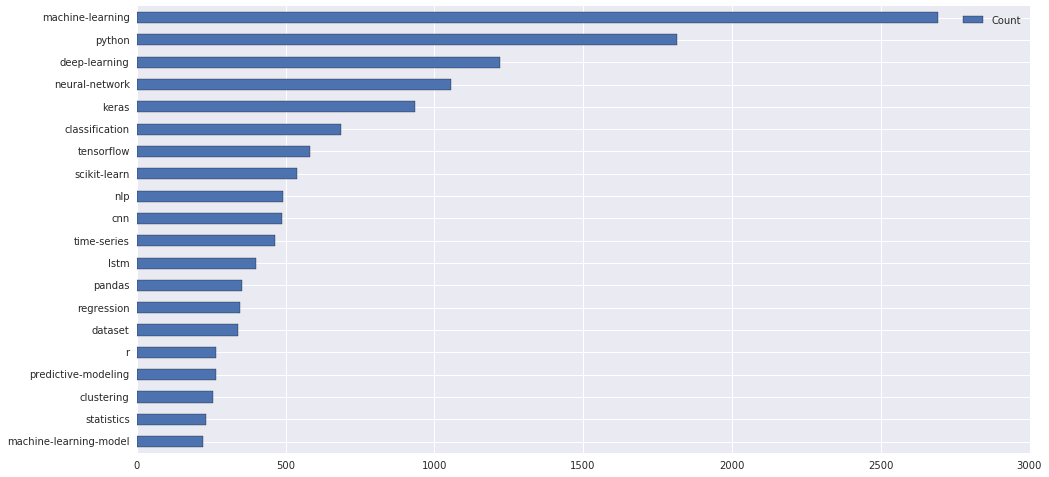

In [11]:
most_used.plot(kind="barh", figsize=(16,8))

In [12]:
some_iterable = "Iterate this!"

for i,c in enumerate(some_iterable):
    print(i,c)

0 I
1 t
2 e
3 r
4 a
5 t
6 e
7  
8 t
9 h
10 i
11 s
12 !


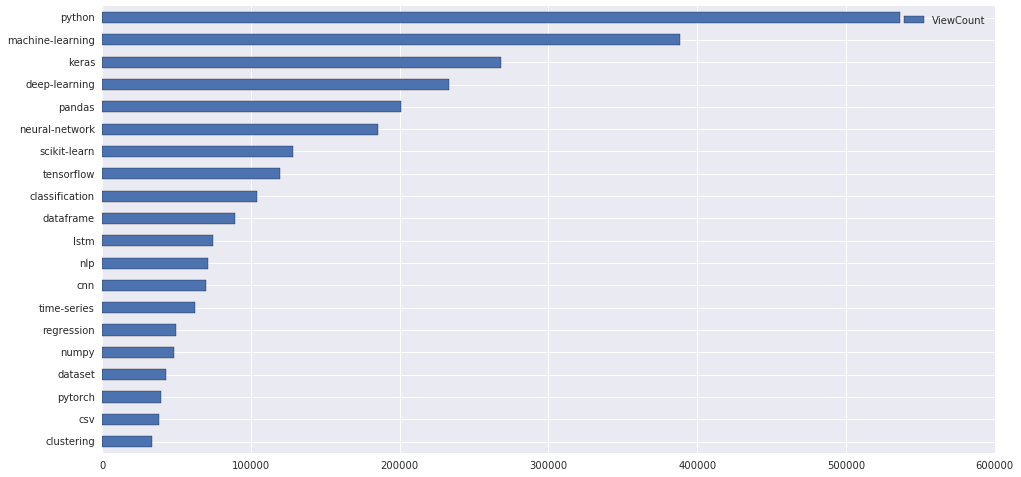

In [13]:
tag_view_count = dict()

for idx, tags in enumerate(questions["Tags"]):
    for tag in tags:
        if tag in tag_view_count:
            tag_view_count[tag] += questions["ViewCount"].iloc[idx]
        else:
            tag_view_count[tag] = 1
            
tag_view_count = pd.DataFrame.from_dict(tag_view_count, orient="index")
tag_view_count.rename(columns={0: "ViewCount"}, inplace=True)

most_viewed = tag_view_count.sort_values(by="ViewCount").tail(20)

most_viewed.plot(kind="barh", figsize=(16,8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f563676ee10>],
      dtype=object)

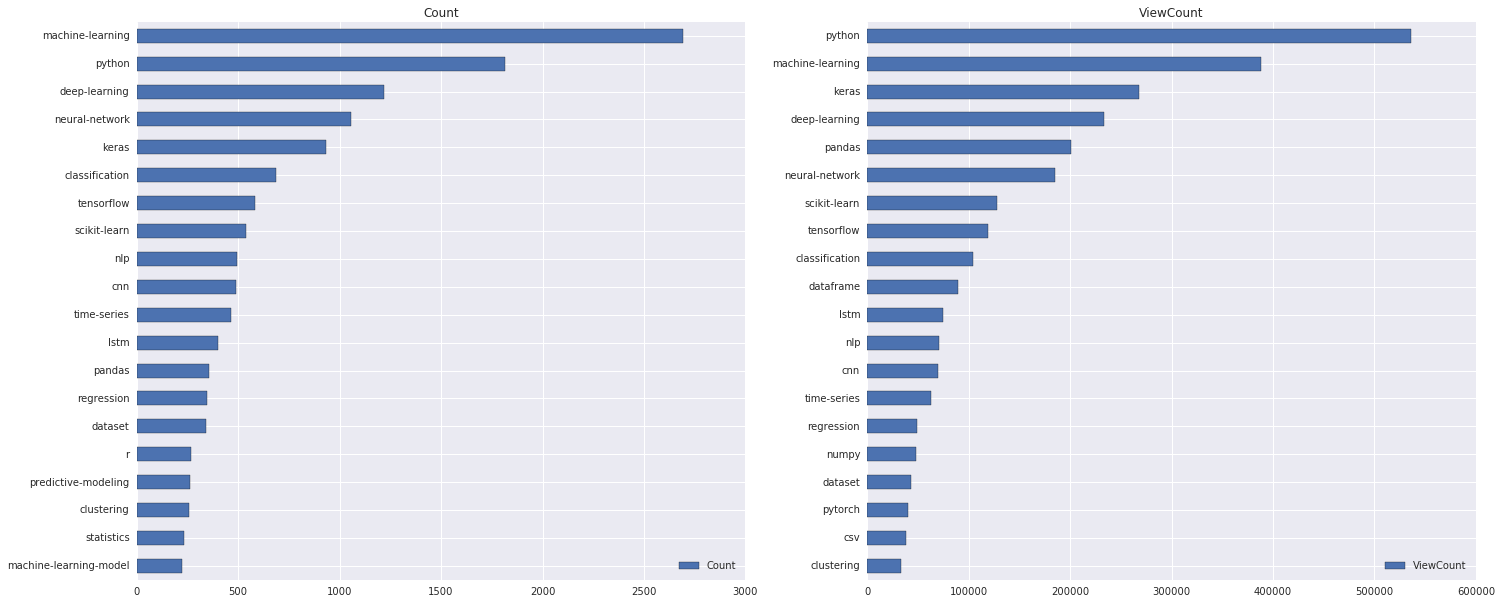

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches((24, 10))
most_used.plot(kind="barh", ax=axes[0], subplots=True)
most_viewed.plot(kind="barh", ax=axes[1], subplots=True)

In [15]:
in_used = pd.merge(most_used, most_viewed, how="left", left_index=True, right_index=True)
in_viewed = pd.merge(most_used, most_viewed, how="right", left_index=True, right_index=True)

In [16]:
all_tags = list(tag_count.index)

In [17]:
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.iloc[0:4,0:4]

,manhattan,h2o,vgg16,ranking
manhattan,NaN,NaN,NaN,NaN
h2o,NaN,NaN,NaN,NaN
vgg16,NaN,NaN,NaN,NaN
ranking,NaN,NaN,NaN,NaN


In [18]:
associations.fillna(0, inplace=True)

for tags in questions["Tags"]:
    associations.loc[tags, tags] += 1

In [19]:
relations_most_used = associations.loc[most_used.index, most_used.index]

def style_cells(x):
    helper_df = pd.DataFrame('', index=x.index, columns=x.columns)
    helper_df.loc["time-series", "r"] = "background-color: yellow"
    helper_df.loc["r", "time-series"] = "background-color: yellow"
    for k in range(helper_df.shape[0]):
        helper_df.iloc[k,k] = "color: blue"
    
    return helper_df

relations_most_used.style.apply(style_cells, axis=None)

,machine-learning-model,statistics,clustering,predictive-modeling,r,dataset,regression,pandas,lstm,time-series,cnn,nlp,scikit-learn,tensorflow,classification,keras,neural-network,deep-learning,python,machine-learning
machine-learning-model,224,3,3,21,7,12,8,4,5,7,4,4,18,9,21,17,10,19,37,139
statistics,3,234,3,16,16,17,16,3,1,22,1,3,6,0,19,3,11,12,35,89
clustering,3,3,257,0,16,5,2,5,3,20,0,9,24,0,12,0,8,2,45,61
predictive-modeling,21,16,0,265,13,7,28,4,13,31,6,1,12,6,27,11,13,32,35,123
r,7,16,16,13,268,6,10,2,3,22,2,4,1,1,10,10,9,5,24,63
dataset,12,17,5,7,6,340,6,14,7,6,11,11,9,9,28,13,20,32,53,99
regression,8,16,2,28,10,6,347,6,11,24,6,2,37,9,34,31,42,21,59,119
pandas,4,3,5,4,2,14,6,354,7,19,1,3,37,3,3,3,1,1,244,62
lstm,5,1,3,13,3,7,11,7,402,87,24,19,2,43,20,133,69,103,61,71
time-series,7,22,20,31,22,6,24,19,87,466,8,0,12,9,25,51,33,44,105,131


In [20]:
for i in range(relations_most_used.shape[0]):
    relations_most_used.iloc[i,i] = pd.np.NaN

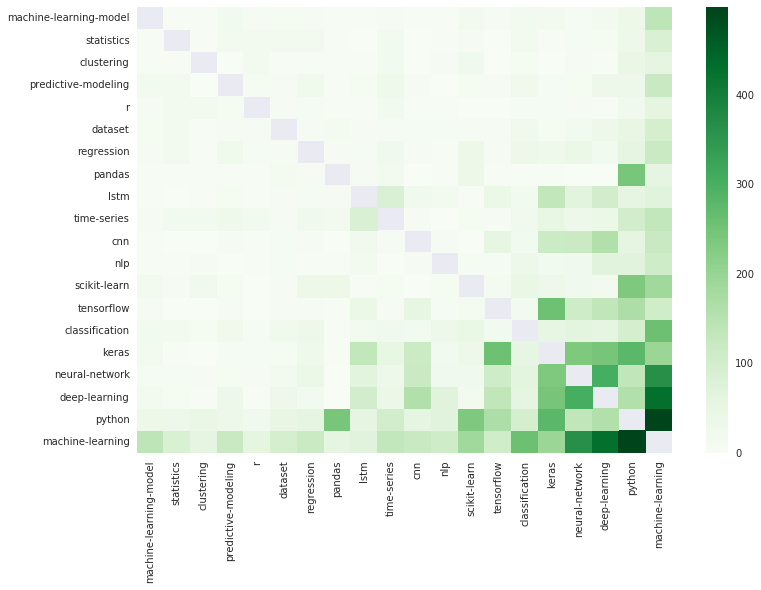

In [21]:
plt.figure(figsize=(12,8))
sns.heatmap(relations_most_used, cmap="Greens", annot=False)

In [22]:
all_q = pd.read_csv("all_questions.csv", parse_dates=["CreationDate"])

In [23]:
all_q["Tags"] = all_q["Tags"].str.replace("^<|>$", "").str.split("><")

In [24]:
def class_deep_learning(tags):
    for tag in tags:
        if tag in ["lstm", "cnn", "scikit-learn", "tensorflow",
                   "keras", "neural-network", "deep-learning"]:
            return 1
    return 0

In [25]:
all_q["DeepLearning"] = all_q["Tags"].apply(class_deep_learning)

In [26]:
all_q.sample(5)

,Id,CreationDate,Tags,DeepLearning
14792,31315,2018-05-07 05:33:13,"[multiclass-classification, metric]",0
5343,17119,2017-02-22 18:47:11,"[algorithms, decision-trees]",0
16674,45262,2019-02-08 12:28:24,"[machine-learning, deep-learning, convnet, rei...",1
6113,58035,2019-08-22 17:10:33,"[classification, xgboost, accuracy, unbalanced...",0
7568,48780,2019-04-07 04:21:53,"[machine-learning, linear-regression]",0


In [27]:
all_q = all_q[all_q["CreationDate"].dt.year < 2020]

In [28]:
def fetch_quarter(datetime):
    year = str(datetime.year)[-2:]
    quarter = str(((datetime.month-1) // 3) + 1)
    return "{y}Q{q}".format(y=year, q=quarter)

all_q["Quarter"] = all_q["CreationDate"].apply(fetch_quarter)

In [29]:
all_q.head()

,Id,CreationDate,Tags,DeepLearning,Quarter
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1,19Q1
1,45418,2019-02-12 00:50:39,[neural-network],1,19Q1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",0,19Q1
3,45426,2019-02-12 04:51:49,[keras],1,19Q1
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode...",0,19Q1


In [30]:
quarterly = all_q.groupby('Quarter').agg({"DeepLearning": ['sum', 'size']})
quarterly.columns = ['DeepLearningQuestions', 'TotalQuestions']
quarterly["DeepLearningRate"] = quarterly["DeepLearningQuestions"]\
                                /quarterly["TotalQuestions"]
# The following is done to help with visualizations later.
quarterly.reset_index(inplace=True)
quarterly.sample(5)

,Quarter,DeepLearningQuestions,TotalQuestions,DeepLearningRate
12,17Q2,226,647,0.349304
18,18Q4,531,1294,0.410355
14,17Q4,353,898,0.393096
6,15Q4,66,382,0.172775
7,16Q1,110,516,0.213178


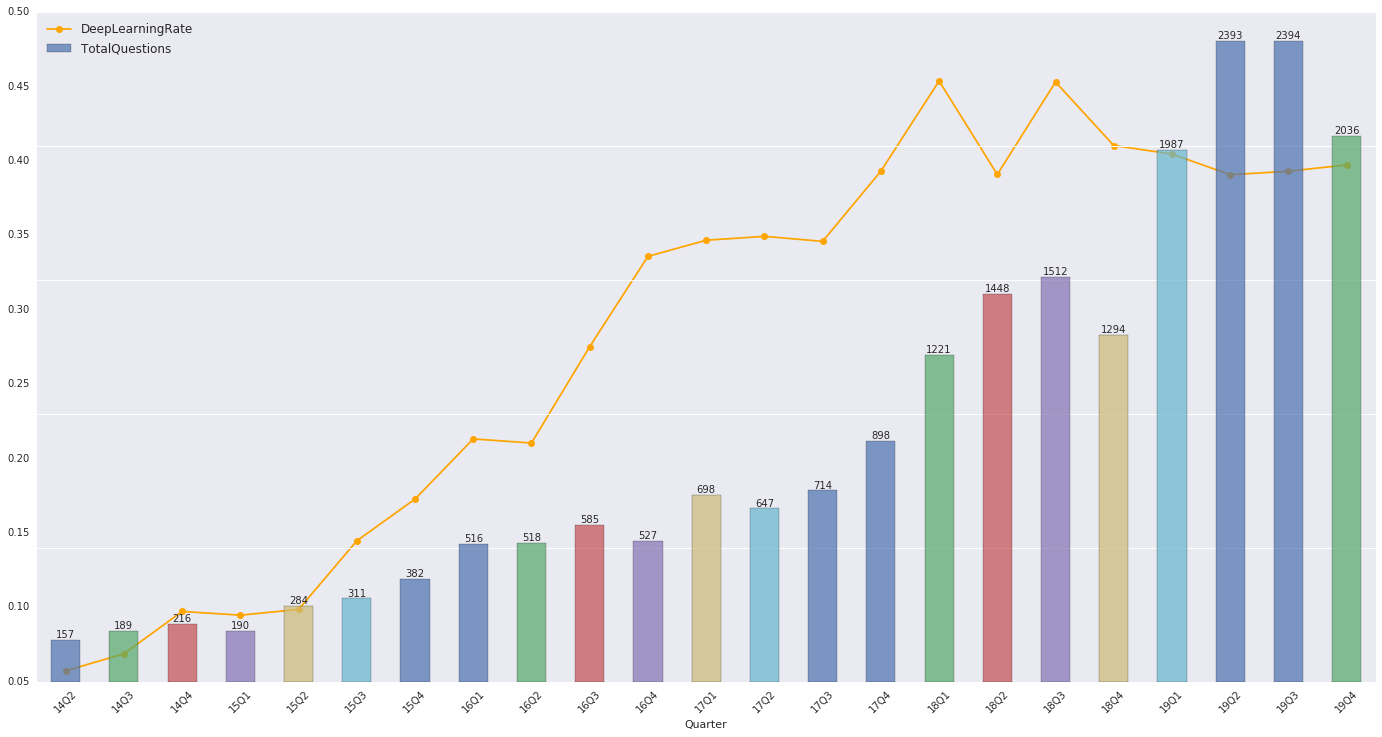

In [31]:
ax1 = quarterly.plot(x="Quarter", y="DeepLearningRate",
                    kind="line", linestyle="-", marker="o", color="orange",
                    figsize=(24,12)
                    )

ax2 = quarterly.plot(x="Quarter", y="TotalQuestions",
                     kind="bar", ax=ax1, secondary_y=True, alpha=0.7, rot=45)

for idx, t in enumerate(quarterly["TotalQuestions"]):
    ax2.text(idx, t, str(t), ha="center", va="bottom")
xlims = ax1.get_xlim()

ax1.get_legend().remove()

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2,
           labels=labels1 + labels2,
           loc="upper left", prop={"size": 12})


for ax in (ax1, ax2):
    for where in ("top", "right"):
        ax.spines[where].set_visible(False)
        ax.tick_params(right=False, labelright=False)